                                                EAS 503 GROUP PROJECT 

OVERVIEW:         The dataset is designed to capture and analyze the potential influence of alcohol consumption on students' 
                  academic performance. It contains information that allows us to explore the relationship between 
                  students alcohol consumption habits and their academic achievements.
                  The data collected provides insights into whether students who engage in alcohol consumption exhibit any 
                  discernible impact on their academic success.

PROBLEM STATEMENT: The primary objective of this study is to predict and understand the desire for education in high school                        students, taking into consideration the potential correlation with variables related to alcohol consumption.                    We aim to delve into the predictive factors that influence students' educational aspirations and, more                          specifically, explore the impact of alcohol addiction on their attitudes towards education

DATASET: "Student_Alcoholism_Grade_v2.csv"

                                                ######  SCHEMA ######

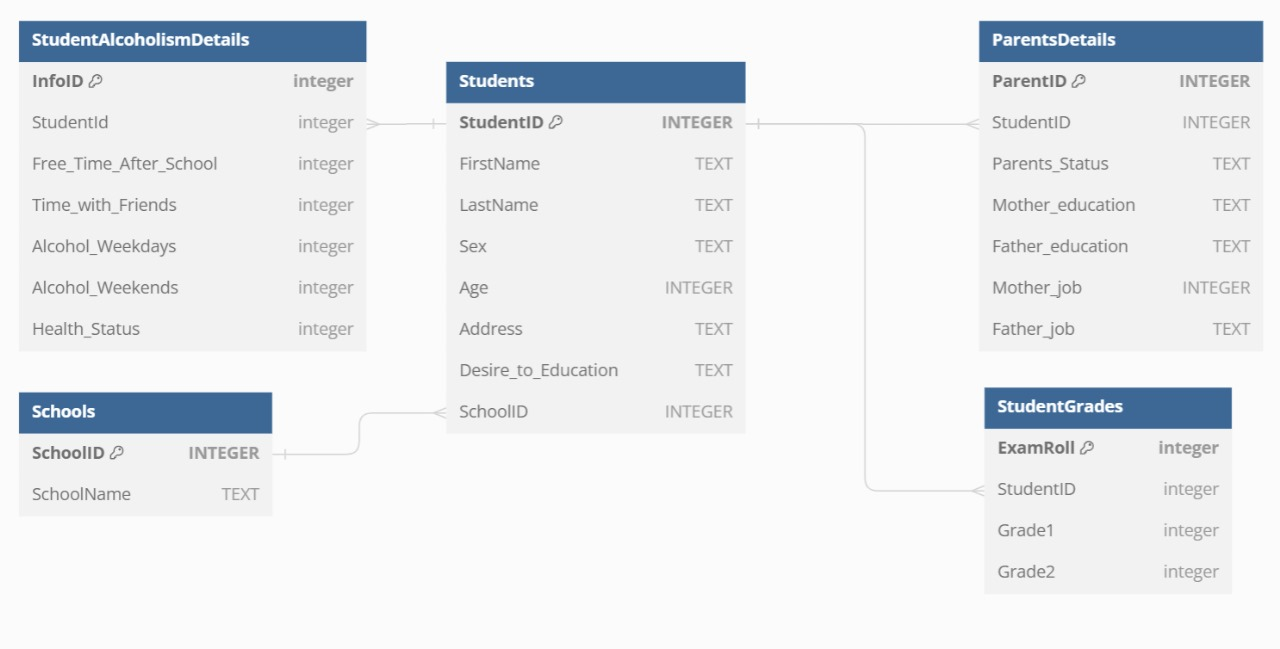

In [17]:
from IPython import display
display.Image("schema.png")

                                              #### NORMALIZING THE DATASET ####

In [2]:
import pandas as pd
import sqlite3
from sqlite3 import Error
from IPython.display import display

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)    
    return conn
    

def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows

def insert_table(conn, values, table):
    if table == 'Schools':
        sql = 'INSERT INTO Schools(SchoolName) VALUES(?) '
    elif table == 'Students':
        sql = 'INSERT INTO Students(FirstName,LastName,Sex,Age,Address,Desire_to_Education,SchoolID) VALUES(?,?,?,?,?,?,?) '
    elif table == 'ParentsDetails':
        sql = 'INSERT INTO ParentsDetails(StudentID, Family_Size, Parents_Status, Mother_education, Father_education, Mother_job, Father_job, Reason) VALUES(?,?,?,?,?,?,?,?) '
    elif table == 'StudentGrades':
        sql =  'INSERT INTO StudentGrades(StudentId,Grade1,Grade2) VALUES(?,?,?) ' 
    elif table == 'StudentAlcoholismDetails':
        sql = ' INSERT INTO StudentAlcoholismDetails(StudentId,Free_Time_After_School,Time_with_Friends, Alcohol_Weekdays, Alcohol_Weekends, Health_Status) VALUES(?,?,?,?,?,?)'

    
    cur = conn.cursor()
    cur.executemany(sql, values)
 
    
def create_schools_table(normalized_database_filename, data_filename):
    with open(data_filename, 'r') as file:
      lines = [line.rstrip('\n') for line in file.readlines()]
      header = lines[0].split('\t')
      lines = lines[1:len(lines)]
      schools = []
        
      for line in lines:
        current_school = []
        current_school = (line.split(',')[0],)
        if current_school not in schools:
          schools.append(current_school)    
    with sqlite3.connect(normalized_database_filename) as conn: 
      create_sql = """CREATE TABLE Schools (  
        [SchoolID] INTEGER NOT NULL PRIMARY KEY,
        [SchoolName] TEXT NOT NULL
        )"""
      create_table(conn, create_sql, 'Schools')
      insert_table(conn, tuple(sorted((schools))), 'Schools') 
    conn = sqlite3.connect(normalized_database_filename)
    

def create_students_table(normalized_database_filename, data_filename, school_to_schoolid_dict):
    
    Desire_to_Education_map = {'Yes':1, 'No':0}
    with open(data_filename, 'r') as file:
      lines = [line.rstrip('\n') for line in file.readlines()]
      header = lines[0].split('\t')
      lines = lines[1:len(lines)]
      students = []
        
      for line in lines:
        current_student = []
        current_student.append(line.split(',')[1].split(' ',1)[0])
        current_student.append(line.split(',')[1].split(' ',1)[1])
        student_bio = line.split(',')[2].split(' ',1)[0]
        current_student.append(student_bio.split(':')[0])
        current_student.append(student_bio.split(':')[1])
        current_student.append(student_bio.split(':')[2])
        current_student.append(Desire_to_Education_map[line.split(',')[11]])
        school_name = line.split(',')[0]
        current_student.append(school_to_schoolid_dict[school_name])
        if current_student not in students:
          students.append(current_student) 
    student_tuple = (sorted(tuple(students)))
    
    with sqlite3.connect(normalized_database_filename) as conn: 
      create_sql = """CREATE TABLE Students (  
        [StudentID] INTEGER NOT NULL PRIMARY KEY,
        [FirstName] TEXT NOT NULL,
        [LastName] TEXT NOT NULL,
        [Sex] TEXT NOT NULL,
        [Age] INTEGER NOT NULL,
        [Address] TEXT NOT NULL,
        [Desire_to_Education] TEXT NOT NULL,
        [SchoolID] INTEGER NOT NULL,
        FOREIGN KEY(SchoolID) REFERENCES Schools(SchoolID) 
        )"""
      create_table(conn, create_sql, 'Students')
      insert_table(conn, tuple(sorted((students))), 'Students')
    conn = sqlite3.connect(normalized_database_filename)
    df = pd.read_sql_query("""SELECT * FROM Students""", conn)
    
def map_id_name_dictionary(normalized_database_filename,table_name):
    
    if (table_name == 'Students'):
        with sqlite3.connect(normalized_database_filename) as conn: 
            students_sql = """Select * from Students"""
            students_tuple = execute_sql_statement(students_sql, conn)
            student_to_studentid_dict = {}
            for student in students_tuple:
                student_name = student[1] + ' ' + student[2]
                student_to_studentid_dict[student_name] = student[0]
        conn.close()
        return (student_to_studentid_dict)
    
    elif (table_name == 'Schools'):
        with sqlite3.connect(normalized_database_filename) as conn: 
            schools_sql = """Select * from Schools"""
            schools_tuple = execute_sql_statement(schools_sql, conn)
            school_to_schoolid_dict = {}
            for school in schools_tuple:
                school_to_schoolid_dict[school[1]] = school[0]
        conn.close()
        return (school_to_schoolid_dict)
    elif (table_name == 'StudentAlcoholism_levels'):
        StudentAlcoholism_levels_dict = {'Very Low':0,'Low':1,'Moderate':2,'High':3, 'Very High':4}
        return (StudentAlcoholism_levels_dict)
    
    elif (table_name == 'StudentAlcoholism_health_status'):
        StudentAlcoholism_health_status_dict = {'Very Poor':0,'Poor':1,'Fair':2,'Good':3, 'Very Good':4}
        return (StudentAlcoholism_health_status_dict)

def create_parents_details_table(normalized_database_filename, data_filename, student_to_studentid_dict):
    with open(data_filename, 'r') as file:
      lines = [line.rstrip('\n') for line in file.readlines()]
      header = lines[0].split('\t')
      lines = lines[1:len(lines)]
      parents_details = []
        
      for line in lines:
        current_info = []
        current_info.append(student_to_studentid_dict[line.split(',')[1]])
        parents_info = line.split(',')[3]
        current_info.append(parents_info.split(':')[0])
        current_info.append(parents_info.split(':')[1])
        current_info.append(parents_info.split(':')[2])
        current_info.append(parents_info.split(':')[3])
        current_info.append(parents_info.split(':')[4])
        current_info.append(parents_info.split(':')[5])
        current_info.append(parents_info.split(':')[6])
        
        if current_info not in parents_details:
          parents_details.append(current_info)                  
    parents_details = (sorted(tuple(parents_details)))
                            
    with sqlite3.connect(normalized_database_filename) as conn: 
      create_sql = """CREATE TABLE ParentsDetails (  
        [ParentID] INTEGER NOT NULL PRIMARY KEY,
        [StudentID] INTEGER NOT NULL,
        [Family_Size] TEXT NOT NULL,
        [Parents_Status] TEXT NOT NULL,
        [Mother_education] TEXT NOT NULL,
        [Father_education] TEXT NOT NULL,
        [Mother_job] INTEGER NOT NULL,
        [Father_job] TEXT NOT NULL,
        [Reason] TEXT NOT NULL,
        FOREIGN KEY(StudentID) REFERENCES Students(StudentID) 
        )"""
      create_table(conn, create_sql, 'ParentsDetails')
      insert_table(conn, tuple(sorted((parents_details))), 'ParentsDetails') 


def create_student_grades_table(normalized_database_filename, data_filename, student_to_studentid_dict):
    header=[]
    values = []
    with open(data_filename, 'r') as file:
        lines = [line.rstrip('\n') for line in file.readlines()]
        header = lines[0].split('\t')
        lines = lines[1:len(lines)]
        for line in lines:
            Grades = line.split(',')[-1]
            Grade1, Grade2 = Grades.split(';')
            StudentId = student_to_studentid_dict[line.split(',')[1]]
            values.append((StudentId,Grade1.strip(), Grade2.strip()))
    values.sort() 
    
    with sqlite3.connect(normalized_database_filename) as conn:
        create_table_Student_Grades_sql = """CREATE TABLE StudentGrades(
            [ExamRoll]integer not null Primary Key,
            [StudentID] integer not null ,
            [Grade1] integer not null,
            [Grade2] integer not null,   
            FOREIGN KEY(StudentID) REFERENCES Students(StudentID)
             )
         """
        create_table(conn, create_table_Student_Grades_sql, 'StudentGrades')
        insert_table(conn, values, 'StudentGrades')

def create_student_Alcoholism_table(normalized_database_filename, data_filename):
    normalized_conn = create_connection(normalized_database_filename, delete_db=False)
    StudentAlcoholism_levels= map_id_name_dictionary(normalized_database_filename,'StudentAlcoholism_levels')
    StudentAlcoholism_health_status = map_id_name_dictionary(normalized_database_filename,'StudentAlcoholism_health_status')

    header=[]
    values = []
    with open(data_filename, 'r') as file:
        lines = [line.rstrip('\n') for line in file.readlines()]
        header = lines[0].split('\t')
        lines = lines[1:len(lines)]
        for line in lines:
            tuplevalue = []
            cols = line.strip().split(',')[-7:-2]
            StudentId = student_to_studentid_dict[line.split(',')[1]]
            tuplevalue.append(StudentId)
            for ele in cols[0:4]:
                tuplevalue.append(StudentAlcoholism_levels[ele])
            tuplevalue.append(StudentAlcoholism_health_status[cols[4]])
            values.append(tuple(tuplevalue))
        values.sort()     

    with sqlite3.connect(normalized_database_filename) as conn:
        create_table_StudentAlcoholism_sql = """CREATE TABLE StudentAlcoholismDetails (
            [InfoID]integer not null Primary Key,
            [StudentId] integer not null ,
            [Free_Time_After_School] integer not null,
            [Time_with_Friends] integer not null,
            [Alcohol_Weekdays] integer not null,
            [Alcohol_Weekends] integer not null,
            [Health_Status] integer not null,
            FOREIGN KEY(StudentId) REFERENCES Students(StudentId)
             );
             """
        create_table(conn, create_table_StudentAlcoholism_sql, 'StudentAlcoholismDetails')
        insert_table(conn, values, 'StudentAlcoholismDetails')

    
def normalized_database_queries(normalized_database_filename):
    conn = sqlite3.connect(normalized_database_filename)
    schools_df = pd.read_sql_query("""SELECT * FROM Schools limit 5""", conn)
    display (schools_df)
    parents_df = pd.read_sql_query("""SELECT * FROM Students limit 5""", conn)
    display (parents_df)
    schools_df = pd.read_sql_query("""SELECT * FROM ParentsDetails limit 5""", conn)
    display (schools_df)
    grades_df = pd.read_sql_query("""SELECT * FROM StudentGrades limit 5""", conn)
    display (grades_df)
    details_df = pd.read_sql_query("""SELECT * FROM StudentAlcoholismDetails limit 5""", conn)
    display (details_df)

    
data_filename = 'Student_Alcoholism_Grade_v2.csv'    
normalized_database_filename = 'normalized_mp.db'
create_schools_table(normalized_database_filename, data_filename)
school_to_schoolid_dict = map_id_name_dictionary(normalized_database_filename,'Schools')
create_students_table(normalized_database_filename, data_filename, school_to_schoolid_dict)
student_to_studentid_dict = map_id_name_dictionary(normalized_database_filename,'Students')
create_parents_details_table(normalized_database_filename, data_filename, student_to_studentid_dict)
create_student_grades_table(normalized_database_filename, data_filename, student_to_studentid_dict)
create_student_Alcoholism_table(normalized_database_filename, data_filename)


                                ######DISPLAYING THE NORMALIZED DATA IN TABLES#######

In [3]:
normalized_database_queries(normalized_database_filename)

,SchoolID,SchoolName
0,1,Gabriel Pereira
1,2,Mousinho da Silveira


,StudentID,FirstName,LastName,Sex,Age,Address,Desire_to_Education,SchoolID
0,1,Aaron,Robb,Male,17,Urban,0,2
1,2,Adam,Deleidi,Male,18,Urban,1,1
2,3,Adam,Federico,Female,17,Urban,1,1
3,4,Adam,Renda,Female,16,Rural,1,2
4,5,Adele,Lubarsky,Female,18,Urban,1,1


,ParentID,StudentID,Family_Size,Parents_Status,Mother_education,Father_education,Mother_job,Father_job,Reason
0,1,1,Above 3,Living Together,High School,Higher Education,Services,other,Other
1,2,2,Above 3,Living Together,Higher Education,Lower Secondary School,Teacher,other,Near Home
2,3,3,Up to 3,Living Together,Lower Secondary School,Primary School,other,other,Near Home
3,4,4,Above 3,Living Together,Primary School,Primary School,Homemaker,other,Other
4,5,5,Above 3,Living Together,Lower Secondary School,Primary School,other,other,Reputation


,ExamRoll,StudentID,Grade1,Grade2
0,1,1,8,9
1,2,2,15,16
2,3,3,11,12
3,4,4,13,12
4,5,5,12,13


,InfoID,StudentId,Free_Time_After_School,Time_with_Friends,Alcohol_Weekdays,Alcohol_Weekends,Health_Status
0,1,1,3,3,2,3,4
1,2,2,2,1,0,3,4
2,3,3,1,2,1,1,1
3,4,4,1,1,3,2,1
4,5,5,2,0,0,0,4


                                              ####SQL QUERIES####

In [4]:
# Query 1: Retrieve Students with High Grades and High Alcohol Consumption
# This query retrieves information about students with high grades and high alcohol consumption:


#StudentAlcoholism_levels_dict = {'Very Low':0,'Low':1,'Moderate':2,'High':3, 'Very High':4}
#StudentAlcoholism_health_status_dict = {'Very Poor':0,'Poor':1,'Fair':2,'Good':3, 'Very Good':4}

from sqlite3 import Error
conn_non_normalized = create_connection('normalized_mp.db')
sql_statement = '''WITH HighGrades AS (
    SELECT
        StudentID,Grade1,Grade2
    FROM
        StudentGrades
    WHERE
        Grade1 >= 15 OR Grade2>=15
),
HighAlcoholConsumption AS (
    SELECT
        StudentID,Alcohol_Weekdays,Alcohol_Weekends
    FROM
        StudentAlcoholismDetails
    WHERE
        Alcohol_Weekdays = 3 OR Alcohol_Weekends = 3
)
SELECT
    Students.StudentID,
    Students.FirstName,
    Students.LastName,
    HG.Grade1,
    HG.Grade2,
    HAC.Alcohol_Weekdays,
    HAC.Alcohol_Weekends
FROM
    Students
JOIN HighGrades HG ON Students.StudentID = HG.StudentID
JOIN HighAlcoholConsumption HAC ON Students.StudentID = HAC.StudentID
;'''
df = pd.read_sql_query(sql_statement, conn_non_normalized)
display(df)



###Analysis - 
##There are only 6 students having good grading and high alcohol consumption. 
##Which inturn explains that on average most of the students with high grades have low or very low alcohol consumption. 

,StudentID,FirstName,LastName,Grade1,Grade2,Alcohol_Weekdays,Alcohol_Weekends
0,2,Adam,Deleidi,15,16,0,3
1,23,Amy,Pasquarello,17,18,0,3
2,219,Gina,Flanagan,12,16,1,3
3,220,Glenda,Colon,15,13,0,3
4,455,Michelle,Nessralla,15,15,0,3
5,485,Patricia,Beggy,15,16,2,3
6,502,Paula,Bolger,16,15,0,3


In [5]:
##Query 2: Retrieve Parental Information for Students in Urban Areas with High Desire for Education
# This query retrieves information about students in urban areas with a high desire for education, 
# along with details about their parents:'''


import sqlite3
from sqlite3 import Error
conn_non_normalized = create_connection('normalized_mp.db')
sql_statement = '''SELECT
    Students.StudentID,
    Students.FirstName,
    Students.LastName,
    Students.Address,
    Students.Desire_to_Education,
    ParentsDetails.Mother_education,
    ParentsDetails.Father_education,
    ParentsDetails.Mother_job,
    ParentsDetails.Father_job
FROM
    Students
JOIN ParentsDetails ON Students.StudentID = ParentsDetails.StudentID
WHERE
    Students.Address = 'Urban'
    AND Students.Desire_to_Education = 1;'''
df = pd.read_sql_query(sql_statement, conn_non_normalized)
display(df)


##Desire_to_Education is 1 for Yes value
##365 students from Urban areas have the desire for Education, their parent's Eduacation Qualification and Job details are displayed

,StudentID,FirstName,LastName,Address,Desire_to_Education,Mother_education,Father_education,Mother_job,Father_job
0,2,Adam,Deleidi,Urban,1,Higher Education,Lower Secondary School,Teacher,other
1,3,Adam,Federico,Urban,1,Lower Secondary School,Primary School,other,other
2,5,Adele,Lubarsky,Urban,1,Lower Secondary School,Primary School,other,other
3,8,Albert,Varga,Urban,1,Primary School,Primary School,other,other
4,11,Alfred,Thompson,Urban,1,Lower Secondary School,Lower Secondary School,other,other
...,...,...,...,...,...,...,...,...,...
360,643,William,Conard,Urban,1,Lower Secondary School,Higher Education,Homemaker,Health
361,645,William,Holt,Urban,1,Higher Education,Lower Secondary School,other,other
362,646,William,Runey Dubey,Urban,1,Higher Education,Lower Secondary School,Teacher,other
363,647,William,Terranova,Urban,1,High School,Lower Secondary School,Homemaker,other


In [6]:
# '''Query 3: Retrieve School-wise Average Grades
# This query calculates the average grades for each school:'''


import sqlite3
from sqlite3 import Error
conn_non_normalized = create_connection('normalized_mp.db')
sql_statement = '''SELECT
    Schools.SchoolID,
    Schools.SchoolName,
    round(AVG(StudentGrades.Grade1),2) AS Average_Grade1,
    round(AVG(StudentGrades.Grade2),2) AS Average_Grade2
FROM
    Schools
JOIN Students ON Schools.SchoolID = Students.SchoolID
JOIN StudentGrades ON Students.StudentID = StudentGrades.StudentID
GROUP BY
    Schools.SchoolID, Schools.SchoolName
ORDER BY Average_Grade1 DESC ,Average_Grade2 DESC;'''
df = pd.read_sql_query(sql_statement, conn_non_normalized)
display(df)


##Analysis
##School 1 (Gabriel Pereira	) has scored highest grades on average compared with School 2(Mousinho da Silveira) 

,SchoolID,SchoolName,Average_Grade1,Average_Grade2
0,1,Gabriel Pereira,11.99,12.14
1,2,Mousinho da Silveira,10.30,10.50


In [7]:
##Query 4: Retrieve Details of Urban Students with age>17 with High Alcohol Consumption on Weekdays
# the query provides details about urban students who are at least 17 years old, including their student details, grades,
# and alcohol consumption habits, with a specific focus on high alcohol consumption on weekdays.

#StudentAlcoholism_levels_dict = {'Very Low':0,'Low':1,'Moderate':2,'High':3, 'Very High':4}
#StudentAlcoholism_health_status_dict = {'Very Poor':0,'Poor':1,'Fair':2,'Good':3, 'Very Good':4}



import sqlite3
from sqlite3 import Error
conn_non_normalized = create_connection('normalized_mp.db')
sql_statement = '''WITH UrbanHighAchievers AS (
    SELECT
        StudentID,
        FirstName,
        LastName
    FROM
        Students
    WHERE
        Address = 'Urban'
        AND Age > 17
)
SELECT
    ST.StudentID,
    ST.FirstName,
    ST.LastName,
    SG.Grade1,
    SG.Grade2,
    SAD.Alcohol_Weekdays,
    SAD.Alcohol_Weekends
FROM
    UrbanHighAchievers ST
JOIN StudentGrades SG ON ST.StudentID = SG.StudentID
JOIN StudentAlcoholismDetails SAD ON ST.StudentID = SAD.StudentID
WHERE
    SAD.Alcohol_Weekdays = 3
ORDER BY SG.Grade1 DESC, SG.Grade2 DESC;'''
df = pd.read_sql_query(sql_statement, conn_non_normalized)
display(df)

##Analysis - 

##There are only 6 students from Urban Areas with age greater than 17 and having high alcohol consumption 

,StudentID,FirstName,LastName,Grade1,Grade2,Alcohol_Weekdays,Alcohol_Weekends
0,488,Patricia,Lampronjan,11,11,3,4
1,525,Richard,Connors,11,10,3,3
2,636,Violetta,Powers,10,10,3,2
3,467,Nancy,Pelletier,9,10,3,4
4,518,R.,Luke Carroll,9,10,3,3
5,486,Patricia,Bode,7,8,3,0


In [8]:
# Query 5: Retrieve Details of Students with Good Health Status and Desire for Education
# the query provides information about students who have both good health status and a desire for education

#StudentAlcoholism_levels_dict = {'Very Low':0,'Low':1,'Moderate':2,'High':3, 'Very High':4}
#StudentAlcoholism_health_status_dict = {'Very Poor':0,'Poor':1,'Fair':2,'Good':3, 'Very Good':4}


import sqlite3
from sqlite3 import Error
conn_non_normalized = create_connection('normalized_mp.db')
sql_statement = '''


-- Common Table Expression (CTE) to identify Students with Desire for Education
WITH DesireForEducationStudents AS (
    SELECT
        StudentID,
        FirstName,
        LastName,
        Age,
        Address,
        Sex,
        Desire_to_Education
    FROM
        Students
    WHERE
        Desire_to_Education = '1'
)
,


-- Common Table Expression (CTE) to identify Students with Good Health Status
 
GoodHealthStudents AS (
    SELECT
        StudentID,
        Health_Status
    FROM
        StudentAlcoholismDetails
    WHERE
        Health_Status >= 3  --  represents good health status
)
SELECT
    HLTH.StudentID,
    HLTH.FirstName,
    HLTH.LastName,
    HLTH.Age,
    HLTH.Address,
    HLTH.Sex,
    EDU.Health_Status,
    HLTH.Desire_to_Education
FROM
GoodHealthStudents  EDU
JOIN DesireForEducationStudents  HLTH ON EDU.StudentID = HLTH.StudentID;'''


df = pd.read_sql_query(sql_statement, conn_non_normalized)
display(df)



##Output Analysis displays the 289 students with good and very good health status and having desire for education

,StudentID,FirstName,LastName,Age,Address,Sex,Health_Status,Desire_to_Education
0,2,Adam,Deleidi,18,Urban,Male,4,1
1,5,Adele,Lubarsky,18,Urban,Female,4,1
2,8,Albert,Varga,16,Urban,Female,4,1
3,10,Alexandra,Banhares-Buckmire,17,Rural,Female,4,1
4,11,Alfred,Thompson,18,Urban,Male,3,1
...,...,...,...,...,...,...,...,...
284,635,Victoria,Hatem,16,Urban,Female,4,1
285,636,Violetta,Powers,19,Urban,Female,4,1
286,639,Wendy,Weidenfeller,17,Rural,Female,4,1
287,641,Will,Gardner,18,Rural,Male,3,1


                                              ####MACHINE LEARNING#####

In [9]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedKFold,cross_val_score,cross_val_predict,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,auc,roc_auc_score,recall_score,classification_report,confusion_matrix, ConfusionMatrixDisplay

normalized_database_filename = 'normalized_mp.db'
def create_analysis_df(db_file):
    conn = sqlite3.connect(db_file)
    sql_query = """SELECT
    Schools.SchoolName,
    Students.StudentID,
    Students.FirstName,
    Students.LastName,
    Students.Sex,
    Students.Age,
    Students.Address,
    Students.Desire_to_Education,
    ParentsDetails.Parents_Status,
    ParentsDetails.Mother_education,
    ParentsDetails.Father_education,
    ParentsDetails.Mother_job,
    ParentsDetails.Father_job,
    StudentGrades.ExamRoll,
    StudentGrades.Grade1,
    StudentGrades.Grade2,
    StudentAlcoholismDetails.Free_Time_After_School,
    StudentAlcoholismDetails.Time_with_Friends,
    StudentAlcoholismDetails.Alcohol_Weekdays,
    StudentAlcoholismDetails.Alcohol_Weekends,
    StudentAlcoholismDetails.Health_Status
FROM
    Students
JOIN Schools ON Students.SchoolID = Schools.SchoolID
JOIN ParentsDetails ON Students.StudentID = ParentsDetails.StudentID
JOIN StudentGrades ON Students.StudentID = StudentGrades.StudentID
JOIN StudentAlcoholismDetails ON Students.StudentID = StudentAlcoholismDetails.StudentId;
 """
    analysis_df = pd.read_sql_query(sql_query, conn)
    return analysis_df

In [10]:
analysis_df = create_analysis_df(normalized_database_filename)
categorical_columns = analysis_df.select_dtypes(include=['object']).columns.tolist()
intcolumns=analysis_df.select_dtypes(include=['float64','int64']).columns.tolist()
encoder=LabelEncoder()
ohe=OneHotEncoder()
analysis_df['Mother_education'] = analysis_df['Mother_education'].astype(str)
analysis_df['Father_education'] = analysis_df['Father_education'].astype(str)

for s in categorical_columns:
    try:
        analysis_df[s]=encoder.fit_transform(analysis_df[s])
    except Exception as e:
        print(f'for {s} we got {e}')

###### Correlation matrix

<Axes: >

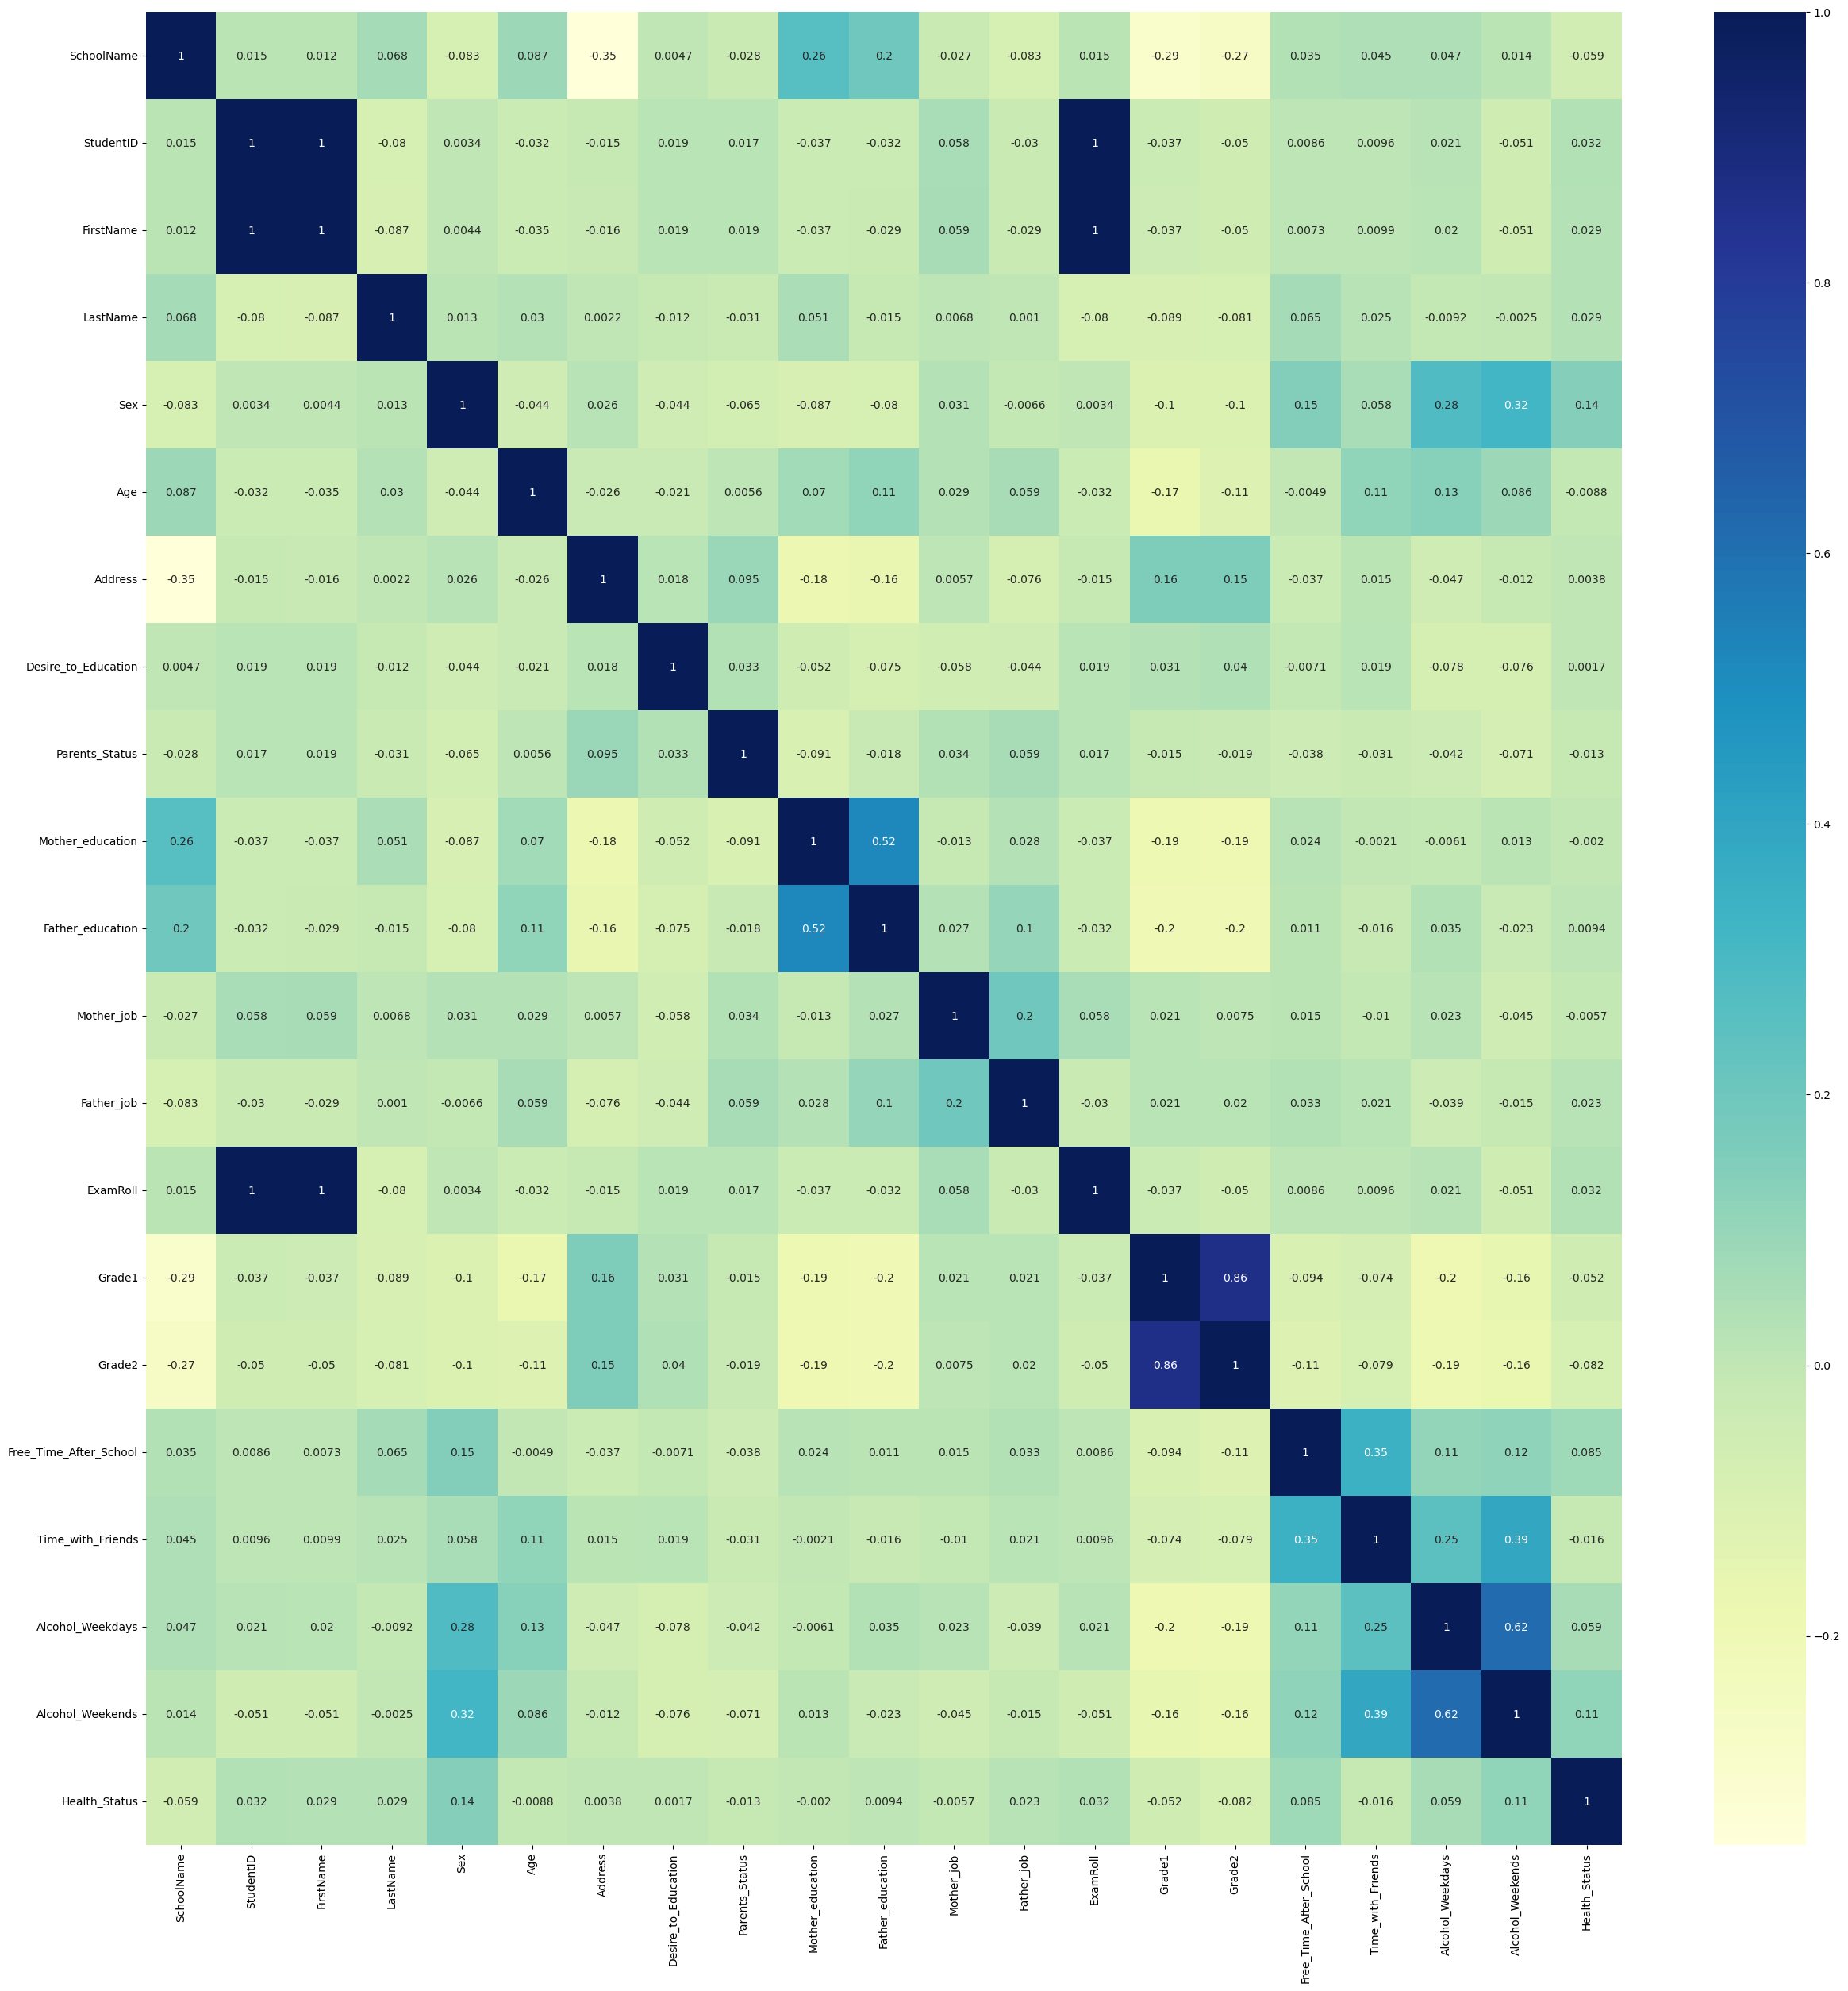

In [11]:
plt.figure(figsize=(30,30))
sns.heatmap(analysis_df.corr(),annot=True, cmap="YlGnBu")

List of top 10 highly correlated attributes with `Desire_to_Education`

In [12]:
mostly_cor=analysis_df.corr()['Desire_to_Education'].drop('Desire_to_Education')
corr_index=mostly_cor.abs().sort_values(ascending=False).head(n=10).index.to_list()
corr_index

['Alcohol_Weekdays',
 'Alcohol_Weekends',
 'Father_education',
 'Mother_job',
 'Mother_education',
 'Father_job',
 'Sex',
 'Grade2',
 'Parents_Status',
 'Grade1']

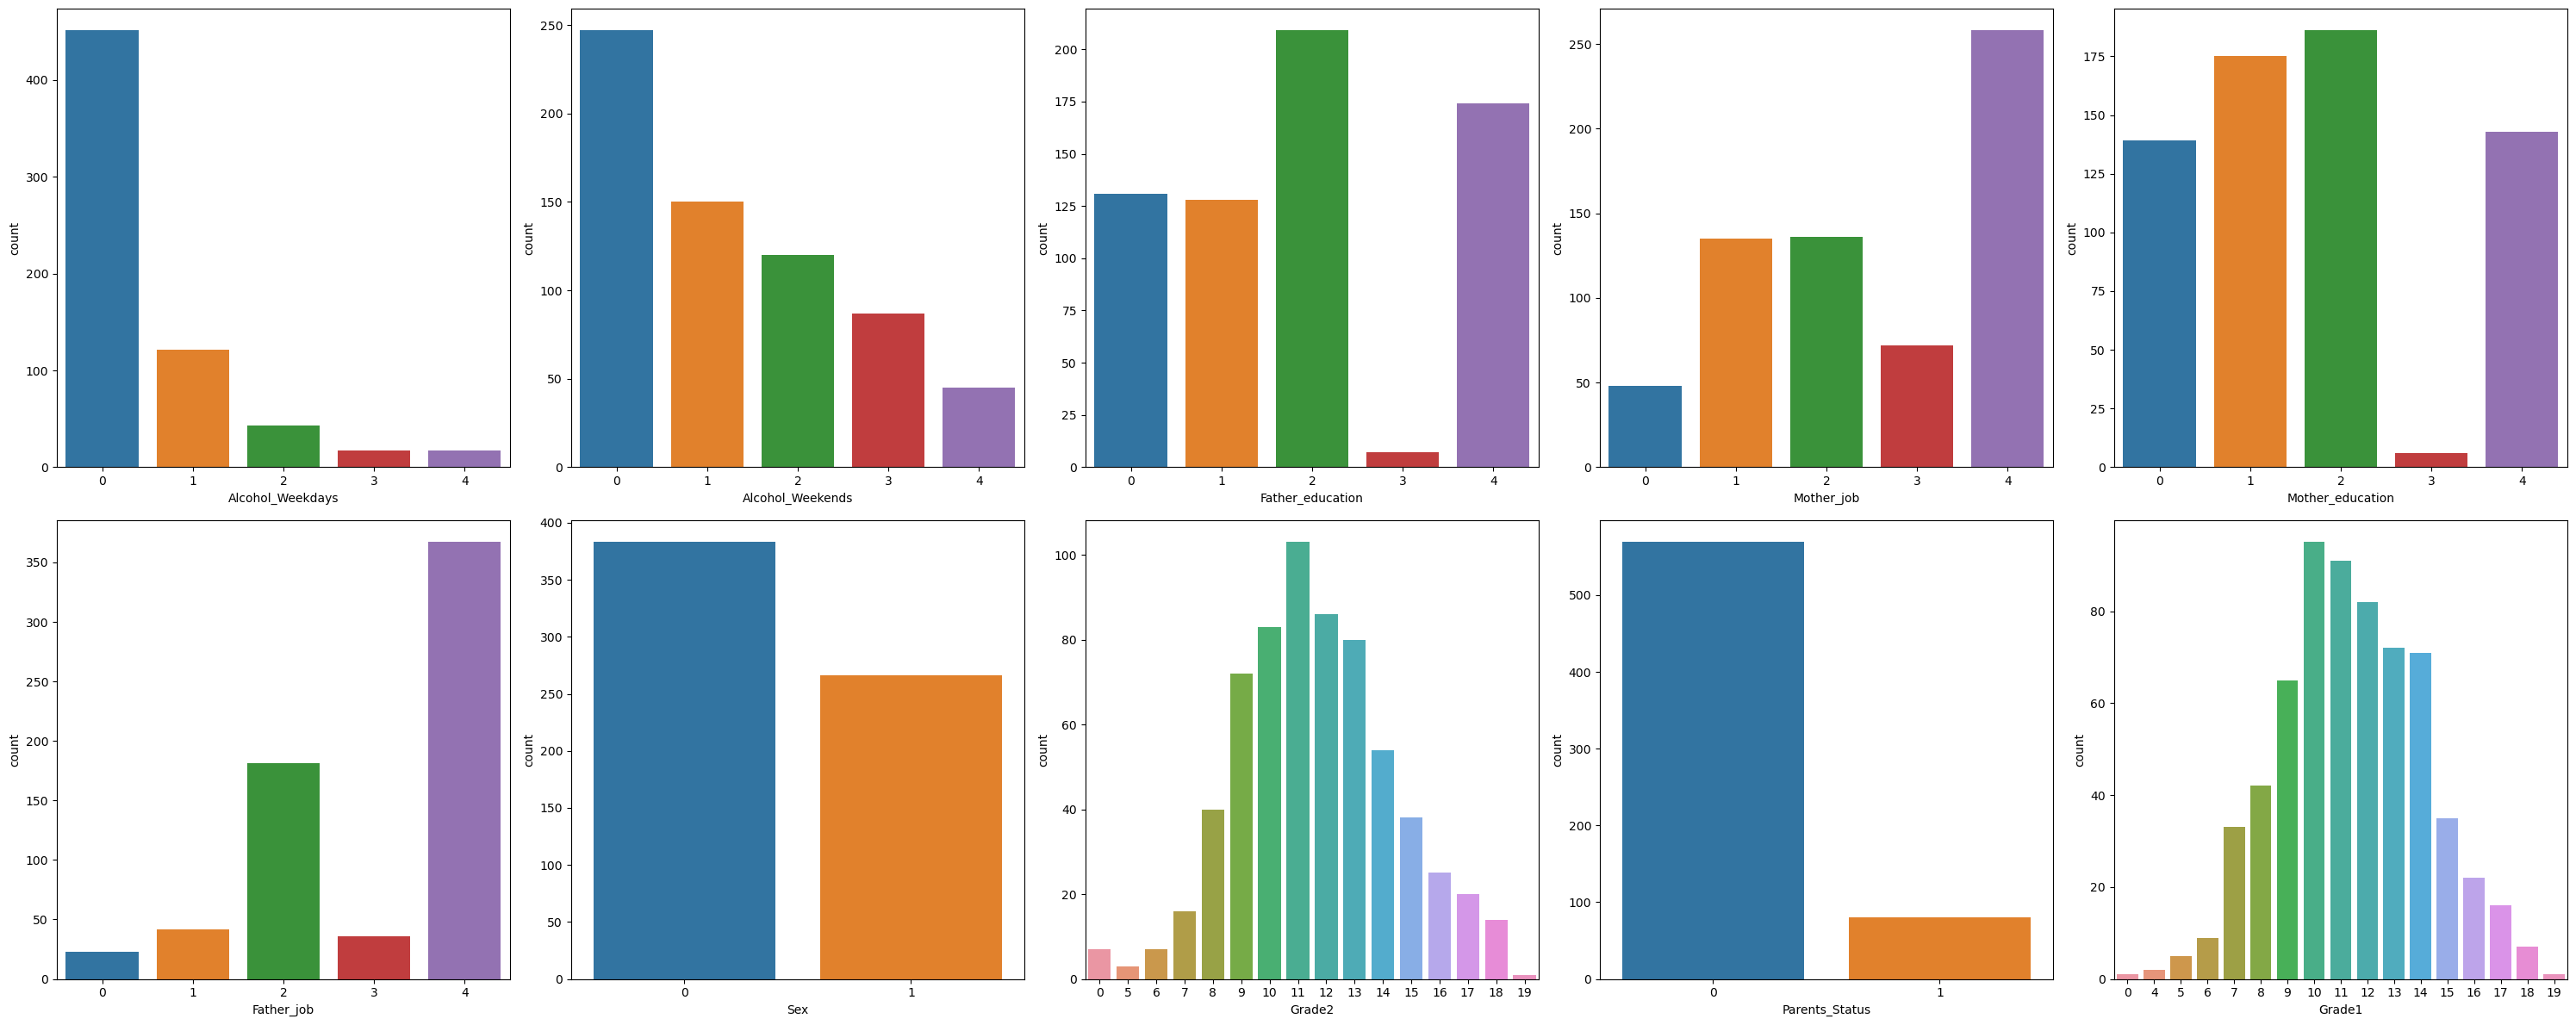

In [13]:
figure, axes = plt.subplots(2, 5, figsize=(30, 12))
axes = axes.flatten()
count = 0
for i in corr_index:
    sns.countplot(data=analysis_df, x=i, ax=axes[count])
    count += 1
plt.tight_layout()
plt.show()

In [14]:
X_df=analysis_df[corr_index]
y_df=analysis_df['Desire_to_Education']
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2)

###### Logistic Regression 

F1 Score: 0.88
Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.79      1.00      0.88       103

    accuracy                           0.79       130
   macro avg       0.40      0.50      0.44       130
weighted avg       0.63      0.79      0.70       130



/Users/keerthi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/keerthi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/keerthi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


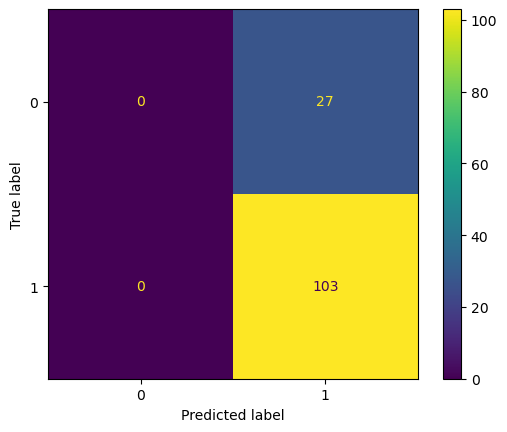

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred),2)
f1_s = f1_score(y_test, y_pred)
print("F1 Score:", round(f1_s,2))
conf_matrix = confusion_matrix(y_test, y_pred)

classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();

###### Random Forest

Accuracy: 0.72
F1 Score: 0.83
Precision: 0.8
Recall: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.15      0.18        27
           1       0.80      0.87      0.83       103

    accuracy                           0.72       130
   macro avg       0.52      0.51      0.51       130
weighted avg       0.68      0.72      0.70       130



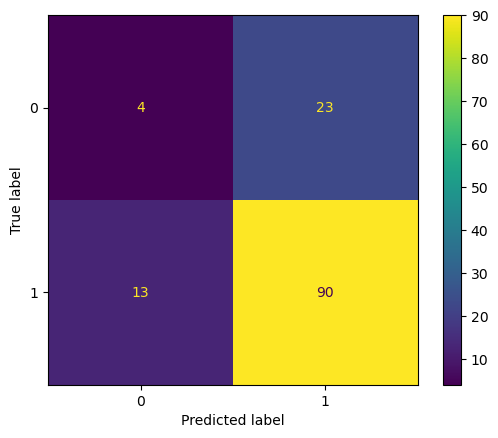

In [16]:
rf_model=RandomForestClassifier(n_estimators=250,min_samples_split=5,min_samples_leaf=2,max_depth=10,class_weight='balanced',random_state=2023)
rf_model.fit(X_train, y_train)
from sklearn.metrics import f1_score
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_s = f1_score(y_test, y_pred)
print("Accuracy:", round(accuracy,2))
print("F1 Score:", round(f1_s,2))
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Precision:", round(precision,2))
print("Recall:", round(recall,2))
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

From the above confusion matrices, we observe that there is class imbalance issue. The number of `No` labels is very less than `Yes` lables. Logistic regression is not able to predict class `No` where as RandomForest classifier is able to identify a few of them. 


In future, we can handle this class imbalance issues by applying oversampling the minority class using techniques such as SMOTE. 

                                                 ####CONCLUSION####